# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  

| Goal                   | What to Do                                                    |
| ---------------------- | ------------------------------------------------------------- |
| Prevent over-smoothing | Add L1 term to loss; raise frequency weight                   |
| Match real stats       | Add correlated complex noise + polynomial baselines           |
| Teach confidence       | Replace last Conv1d with BayesianTorch layer                  |
| Fine-tune realism      | Convert 10–20 real FIDs → `.asc` → arrays → 1–3 epochs low-LR |
| Quantify success       | Track ΔSNR, FFT correlation, and residual histograms          |


## 🔧 Recent Improvements (Nov 14, 2025)

### Problems Identified:
1. **Negative ΔSNR**: Model was degrading SNR instead of improving it
2. **Scale Mismatch**: Real data ~12x larger amplitude than synthetic training data
3. **Poor Noise Model**: Noise referenced tail (near zero) instead of signal
4. **Over-smoothing**: Model removed signal along with noise
5. **Aggressive Fine-tuning**: Learning rate too high, causing instability

### Fixes Applied:

#### 1. **Synthetic Data Generation** (`synth_batch_phys`)
- ✅ Noise now scaled relative to **early signal RMS** (first 20%), not tail
- ✅ Ensures consistent SNR across different T2 decay rates
- ✅ More realistic noise characteristics

#### 2. **Loss Function** (`combined_loss`)
- ✅ Added **L1 regularization** (weight=0.05) to prevent over-smoothing
- ✅ **Sqrt weighting** in spectral loss (reduces noise floor emphasis)
- ✅ Better balance: freq_weight=0.5, time_weight=0.4
- ✅ Signal preservation prioritized over aggressive denoising

#### 3. **Preprocessing** (`_preprocess_pair`)
- ✅ New `preserve_signal=True` flag
- ✅ Normalizes by **noise floor** (tail RMS) instead of signal peak
- ✅ Maintains SNR relationships across files

#### 4. **Fine-tuning Strategy**
- ✅ Learning rate: 8e-4 → **1e-5** (200x reduction)
- ✅ **Early stopping** with patience=3 epochs
- ✅ Tracks best model by ΔSNR improvement
- ✅ Self-supervised loss with consistency regularization

#### 5. **Training Hyperparameters**
- ✅ Epochs: 40 → **50** (more training)
- ✅ Steps per epoch: 120 → **150** (more updates)
- ✅ Noise schedule: Lower levels [0.035→0.02] (more realistic)
- ✅ Real fine-tune epochs: 15 → **10 with early stopping**

#### 6. **SNR Calculation** (`_snr_from_env`)
- ✅ More robust: uses first 20% for signal, last 20% for noise
- ✅ Guards against unrealistic SNR from tiny noise floors

#### 7. **Validation & Diagnostics**
- ✅ New validation cell with detailed metrics
- ✅ Tracks: SNR before/after, noise reduction %, signal preservation %
- ✅ Per-file and aggregate statistics

### Expected Results:
- **Positive ΔSNR** on most files
- Better signal preservation (>95%)
- Noise reduction without removing peaks
- More stable fine-tuning convergence

### Next Steps:
1. Run cells 1-14 to train/fine-tune with improvements
2. Check validation results (new diagnostic cell)
3. If still negative ΔSNR, may need architectural changes (deeper network, attention, etc.)

In [1]:
# --- Environment & Imports ---
import os, glob, math, time, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt, pandas as pd
from importlib import reload

In [2]:
"""
neural_net.py

This module hosts two families of models:
1) A simple TensorFlow/Keras MLP kept for legacy demos (SimpleNeuralNetwork)
2) The PyTorch denoiser used by the NMR notebook (DenoiseNetPhysics) + helpers

The PyTorch section provides a build-and-load flow so the notebook can
instantiate the architecture first and then load the latest checkpoint.
"""

from typing import Optional, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
import math  # <-- needed for math.pi in synth_batch_phys
import numpy as np  # ensure numpy is always available even if TF import fails


# --- (A) Legacy TensorFlow demo (kept for backwards-compatibility) ---
try:
    import numpy as np
    import tensorflow as tf  # type: ignore
    from tensorflow import keras  # type: ignore
    from tensorflow.keras import layers  # type: ignore

    class SimpleNeuralNetwork:
        def __init__(self, input_shape, num_classes):
            self.model = self.build_model(input_shape, num_classes)

        def build_model(self, input_shape, num_classes):
            model = keras.Sequential()
            model.add(layers.Input(shape=input_shape))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.Dense(num_classes, activation='softmax'))
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            return model

        def train(self, x_train, y_train, epochs=10, batch_size=32, validation_data=None):
            self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

        def evaluate(self, x_test, y_test):
            return self.model.evaluate(x_test, y_test)

        def predict(self, x):
            return self.model.predict(x)
except Exception:
    # TensorFlow may be unavailable in some environments; skip gracefully.
    pass


# --- (B) PyTorch denoiser used in the NMR workflow ---
import os
import torch
import torch.nn as nn
import torch.nn.functional as F


class DilatedResBlock(nn.Module):
    """Residual block with dilated Conv1d layers.

    Keeps input/output channel count identical and adds a residual connection.
    """

    def __init__(self, channels: int, dilation: int = 1, k: int = 11):
        super().__init__()
        pad = dilation * ((k - 1) // 2)
        self.conv1 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.conv1(x))
        h = self.conv2(h)
        return F.relu(x + h)


class DenoiseNetPhysics(nn.Module):
    """Dilated Conv1D residual denoiser for complex FID (2 channels: real, imag)."""

    def __init__(self, in_ch: int = 2, hidden: int = 64, k: int = 11, dilations=(1, 2, 4, 8, 16, 32)):
        super().__init__()
        self.name = "DenoiseNetPhysics"
        self.inp = nn.Conv1d(in_ch, hidden, k, padding=(k - 1) // 2)
        self.blocks = nn.Sequential(*[DilatedResBlock(hidden, d, k) for d in dilations])
        self.out = nn.Conv1d(hidden, in_ch, k, padding=(k - 1) // 2)  # residual head

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.inp(x))
        h = self.blocks(h)
        resid = self.out(h)
        return x + resid


# ---- Helpers for checkpoint management ----
def count_params(model: nn.Module) -> Tuple[int, int]:
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


def load_checkpoint(model: nn.Module, ckpt_path: str, map_location: Optional[torch.device] = None, strict: bool = False) -> Tuple[bool, str]:
    """Load a checkpoint into an already-instantiated model.

    Returns (ok, message). ok=False if file missing or load failed.
    """
    if not os.path.exists(ckpt_path):
        return False, f"[Info] Checkpoint not found: {ckpt_path}"
    try:
        ckpt = torch.load(ckpt_path, map_location=map_location or 'cpu')
        state = ckpt.get('model_state', ckpt)
        missing, unexpected = model.load_state_dict(state, strict=strict)
        msg = f"[Info] Loaded checkpoint: {ckpt_path}"
        if missing:
            msg += f" | missing={len(missing)}"
        if unexpected:
            msg += f" | unexpected={len(unexpected)}"
        return True, msg
    except Exception as e:
        return False, f"[Warn] Failed to load {ckpt_path}: {e}"



def build_model_from_latest(checkpoints_dir: str, latest_name: str = "DenoiseNetPhysics_latest.pth",
                            device: Optional[torch.device] = None) -> Tuple[nn.Module, Optional[str]]:
    """Instantiate DenoiseNetPhysics, then attempt to load the latest checkpoint.

    Returns (model, loaded_from_path_or_None).
    """
    device = device or torch.device('cpu')
    model = DenoiseNetPhysics().to(device)
    latest_path = os.path.join(checkpoints_dir, latest_name)
    ok, msg = load_checkpoint(model, latest_path, map_location=device, strict=False)
    print(msg)
    # If checkpoint loaded but contained non-finite params, reinitialize to safe defaults
    if ok and _has_non_finite_params(model):
        print("[Warn] Loaded checkpoint contains NaN/Inf parameters → reinitializing model weights")
        _reinit_model_(model)
        ok = False
    setattr(model, "_loaded_from", latest_path if ok else None)
    return model, (latest_path if ok else None)


__all__ = [
    # TF demo
    'SimpleNeuralNetwork',
    # Torch denoiser
    'DilatedResBlock', 'DenoiseNetPhysics',
    # helpers
    'count_params', 'load_checkpoint', 'build_model_from_latest',
    # training utilities
    'synth_batch_phys', 'combined_loss',
]


# In Cell 4, find and replace the synth_batch_phys function with:

def synth_batch_phys(batch_size=16, L=2048, snr_std=0.025, device='cpu'):
    """
    Generate synthetic complex FID batches with physically motivated noise.
    Now with realistic amplitude scaling to match real data.
    
    Returns (fid_noisy, fid_clean), each shape (batch_size, 2, L).
    """
    import math
    
    B, device_obj = batch_size, torch.device(device)
    t = torch.linspace(0, L - 1, L, device=device_obj)
    
    # Random parameters for each sample
    T2_vals = torch.empty(B, device=device_obj).uniform_(0.15 * L, 0.5 * L)
    freq_vals = torch.empty(B, device=device_obj).uniform_(-0.05, 0.05)
    phase_vals = torch.empty(B, device=device_obj).uniform_(0, 2 * math.pi)
    
    decay = torch.exp(-t.unsqueeze(0) / T2_vals.unsqueeze(1))
    osc = torch.cos(2 * math.pi * freq_vals.unsqueeze(1) * t.unsqueeze(0) + phase_vals.unsqueeze(1))
    
    real_clean = (decay * osc).unsqueeze(1)
    imag_clean = (decay * torch.sin(2 * math.pi * freq_vals.unsqueeze(1) * t.unsqueeze(0) + phase_vals.unsqueeze(1))).unsqueeze(1)
    fid_clean = torch.cat([real_clean, imag_clean], dim=1)
    
    # Noise scaled to early-signal RMS (first 20%)
    early_len = max(64, int(0.2 * L))
    early_rms = torch.sqrt((fid_clean[:, :, :early_len] ** 2).mean(dim=(1, 2), keepdim=True))
    noise_level = snr_std * early_rms.unsqueeze(-1)
    
    noise = torch.randn(B, 2, L, device=device_obj) * noise_level
    fid_noisy = fid_clean + noise
    
    # ✅ SCALE TO MATCH REAL DATA (avg std ≈ 15)
    target_scale = 15.0
    current_scale = fid_noisy.std().item()
    scale_factor = target_scale / (current_scale + 1e-12)
    
    fid_clean = fid_clean * scale_factor
    fid_noisy = fid_noisy * scale_factor
    
    return fid_noisy.float(), fid_clean.float()

# ...existing code...
import torch
import torch.nn.functional as F
# ...existing code...

def _complex_fft(signal_2ch: torch.Tensor):
    """Full complex FFT of a two-channel (real, imag) signal.
    signal_2ch: (B,2,L) float32
    returns: (B,L) complex spectrum (torch.cfloat)
    """
    real, imag = signal_2ch[:, 0], signal_2ch[:, 1]
    z = torch.complex(real, imag)
    return torch.fft.fft(z, dim=-1, norm='ortho')


def _rfft_mag(signal_2ch: torch.Tensor, eps: float = 1e-6, half: bool = True):
    """Magnitude spectrum from complex input without using rfft on complex.
    We compute complex FFT, then optionally take half-spectrum magnitude.
    """
    real, imag = signal_2ch[:, 0], signal_2ch[:, 1]
    z = torch.complex(real, imag)
    Z = torch.fft.fft(z, dim=-1, norm='ortho')
    mag = torch.abs(Z)
    if half:
        L = z.shape[-1]
        mag = mag[..., : (L // 2) + 1]
    return torch.clamp(mag, min=eps)



def combined_loss(pred: torch.Tensor,
                  target: torch.Tensor,
                  dt: Optional[float] = None,
                  x_ref: Optional[torch.Tensor] = None,
                  freq_weight: float = 0.5,
                  time_weight: float = 0.4,
                  l1_weight: float = 0.05,
                  tv_weight: float = 0.0,
                  self_denoise_consistency: float = 0.05,
                  eps: float = 1e-6) -> torch.Tensor:
    """
    Improved hybrid loss for better signal preservation:
    - Balanced time/freq domains
    - L1 regularization to prevent over-smoothing
    - Phase-aware spectral loss
    pred/target: (B,2,L)
    dt: dwell time (optional, reserved)
    x_ref: original noisy input (optional, encourages minimal distortion)
    Returns finite scalar tensor; non-finite intermediates are clamped.
    """
    # Time-domain MSE
    td_mse = F.mse_loss(pred, target)

    # Frequency-domain magnitude loss (half-spectrum)
    mag_p = _rfft_mag(pred, eps=eps)
    mag_t = _rfft_mag(target, eps=eps)
    fd_mse = F.mse_loss(mag_p, mag_t)

    # ✅ Improved: Focus on preserving strong peaks (don't over-weight noise floor)
    # Use sqrt weighting instead of linear to reduce emphasis on noise
    mag_t_norm = mag_t / (mag_t.max(dim=-1, keepdim=True)[0] + eps)
    weight = torch.sqrt(mag_t_norm + eps)
    fd_weighted = torch.mean(((mag_p - mag_t) ** 2) * weight)
    freq_term = 0.7 * fd_mse + 0.3 * fd_weighted

    # ✅ L1 sparsity on residual (prevents removing too much signal)
    l1_term = torch.mean(torch.abs(pred - target)) if l1_weight > 0 else torch.zeros((), device=pred.device)

    # Simple total variation (smoothness) along time
    tv = torch.mean(torch.abs(pred[:, :, 1:] - pred[:, :, :-1])) if tv_weight > 0 else torch.zeros((), device=pred.device)

    # Consistency: keep close to input if self-denoising (avoid hallucination)
    cons = F.mse_loss(pred, x_ref) if (x_ref is not None and self_denoise_consistency > 0) else torch.zeros((), device=pred.device)

    total = (freq_weight * freq_term +
             time_weight * td_mse +
             l1_weight * l1_term +
             tv_weight * tv +
             self_denoise_consistency * cons)

    if not torch.isfinite(total):
        # Avoid propagating NaNs/Infs
        return torch.zeros((), device=pred.device, dtype=pred.dtype)
    return total


# ----- Utility: check and reinitialize model if non-finite -----
def _has_non_finite_params(model: nn.Module) -> bool:
    for _, p in model.named_parameters():
        if p is not None and not torch.isfinite(p).all():
            return True
    return False


def _reinit_model_(model: nn.Module) -> None:
    """In-place Kaiming initialization of Conv1d/Linear layers."""
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.Linear)):
            if m.weight is not None:
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if getattr(m, 'bias', None) is not None and m.bias is not None:
                nn.init.zeros_(m.bias)
# ...existing code...

In [3]:
# --- Import model code + instantiate before loading checkpoint ---
import os, torch
from importlib import reload

# Ensure we are in project root
os.chdir(r"C:\Users\Windows User\NMR-Project")

# Make sure functions is a package
init_path = os.path.join("functions", "__init__.py")
if not os.path.exists(init_path):
    open(init_path, "a").close()

# Import neural_net module
import functions.neural_net as nnets
reload(nnets)  # safe during edits

from functions.neural_net import DenoiseNetPhysics, build_model_from_latest, count_params

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Device] Using {device}")

# Checkpoint dir + latest name
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
LATEST_NAME = "DenoiseNetPhysics_latest.pth"

# Build first, then load weights
# --- Allow PyTorch to load numpy scalar globals safely (ONLY needed for your own checkpoints) ---
from torch.serialization import add_safe_globals
import numpy._core.multiarray
add_safe_globals([numpy._core.multiarray.scalar])
# --- Build model and load latest checkpoint ---
model_physics, loaded_path = build_model_from_latest(CHECKPOINT_DIR, latest_name=LATEST_NAME, device=device)

# Param report
total_params, trainable_params = count_params(model_physics)
print(f"Model: {model_physics.__class__.__name__} | params={total_params:,} trainable={trainable_params:,} | ckpt={loaded_path}")

# Optional concise architecture head
print("Architecture head:")
for i, line in enumerate(repr(model_physics).splitlines()):
    if i > 20: 
        print("  ..."); break
    print(" ", line)

[Device] Using cpu
[Warn] Failed to load C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.dtype])` or the `torch.serialization.safe_globals([numpy.dtype])` context manager to allowlist this global if you trust this class/function.

Check the

#### This is an optimizer. I should ask about this

In [4]:
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

## 🎛 Hyperparameter Guide (Training Config)

---

### **1️⃣ EPOCHS = 6**
- **What it means:** One full pass over your training curriculum.  
- **Intuition:** The model “reads” the entire (synthetic) dataset once per epoch; 6 epochs = 6 passes.  
- **Tune:**  
  - ✅ Increase if underfitting (loss still improving, predictions weak).  
  - ⚠️ Decrease if overfitting (train loss drops, validation/real performance worsens).  

---

### **2️⃣ STEPS_PER_EPOCH = 40**
- **What it means:** Number of mini-batches per epoch (you synthesize data on the fly).  
- **Intuition:** After 40 updates, call it an epoch even without a fixed dataset size.  
- **Tune:**  
  - ✅ Increase for more gradient updates per epoch (more compute).  
  - ⚠️ Decrease if training is too slow or your data volume is small.  

---

### **3️⃣ BATCH_SIZE = 8**
- **What it means:** Samples processed together before one optimizer step.  
- **Intuition:**  
  - Smaller batches → noisier updates, better generalization, less memory.  
  - Larger batches → smoother updates, faster, but more memory.  
- **Tune:**  
  - ✅ Increase if GPU RAM allows (more stable/faster).  
  - ⚠️ Decrease if memory-limited or want extra regularization via noisier gradients.  

---

### **4️⃣ CROP_LEN = 2048**
- **What it means:** Length of each input segment (points) from the FID.  
- **Intuition:** Train on fixed-size windows to learn local patterns without full-length overhead.  
- **Tune:**  
  - ✅ Increase for longer-range patterns or receptive field coverage.  
  - ⚠️ Decrease if memory is tight or to allow more slice variety per trace.  

---

### **5️⃣ NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]**
- **What it means:** Per-epoch noise level (post tail-RMS scaling) for synthetic training.  
- **Intuition:** Start harder (noisy) and gradually cleaner to refine details — **curriculum learning**.  
- **Tune:**  
  - ✅ Increase if real FIDs are very noisy (robustness).  
  - ⚠️ Decrease if convergence is unstable or data is already clean.  

---

### **6️⃣ REAL_FINETUNE_EPOCHS = 1**
- **What it means:** Passes over your real `.asc` files for self-denoising fine-tuning.  
- **Intuition:** Adapt filters from synthetic data to real acquisition artifacts.  
- **Tune:**  
  - ✅ Increase with more/better real data for stronger adaptation.  
  - ⚠️ Keep low if dataset is small to avoid overfitting.  

---

### **7️⃣ REAL_BATCH_SIZE = 8**
- **What it means:** Batch size used during real-data fine-tuning.  
- **Intuition:** Same trade-offs as `BATCH_SIZE` but applied to real data.  
- **Tune:**  
  - ✅ Increase for stability/throughput if memory allows.  
  - ⚠️ Decrease to fit larger crops or longer traces.  

---

## **📌 At a Glance**
- **Epochs:** how many times the model sees the dataset.  
- **Steps per epoch:** how many mini-updates per epoch.  
- **Batch size:** how many spectra per mini-update.  
- **Crop length:** how long each training slice is.  
- **Noise schedule:** how noisy each epoch’s synthetic data is.  
- **Real fine-tuning:** extra passes on actual data to specialize.  


In [5]:
import importlib, functions.neural_net as nnets
importlib.reload(nnets)
from functions.neural_net import combined_loss, synth_batch_phys
from torch.amp import autocast, GradScaler

# ✅ IMPROVED Training Configuration
# Curriculum training with improved loss function

EPOCHS = 10               # More epochs for better learning
STEPS_PER_EPOCH = 60      # More steps per epoch
BATCH_SIZE = 8
CROP_LEN = 2048
# ✅ Lower noise levels for more realistic training (gradual curriculum)
NOISE_SCHEDULE = [0.05, 0.04, 0.035, 0.03, 0.025, 0.02, 0.018, 0.015, 0.012, 0.01]  

# ✅ Real-data fine-tune settings (more aggressive)
REAL_FINETUNE_EPOCHS = 10   # More epochs with early stopping
REAL_BATCH_SIZE = 8

In [6]:
# Global synthetic dwell time (seconds) - MUST come before training!
dt_synth = 1.0e-4  # adjust if your synthetic FIDs should mimic another SW (SW ≈ 1/dt)
print(f"[dt] Synthetic dwell time set to {dt_synth} s")

[dt] Synthetic dwell time set to 0.0001 s


In [7]:
# --- FID Processing + Metrics (Unified Replacement Cell) ---

import os, glob, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt

assert 'model_physics' in globals(), "model_physics not defined (run model build cell first)"
assert 'device' in globals(), "device not defined (run device cell first)"

# Config - Force reset to use all data (not just training_data)
data_dir = r"C:\Users\Windows User\NMR-Project\data"  # Use entire data folder
save_outputs = globals().get('save_outputs', False)
out_dir = os.path.join(data_dir, "denoised")
if save_outputs:
    os.makedirs(out_dir, exist_ok=True)

print(f"[Config] data_dir={data_dir} save_outputs={save_outputs}")

# Recursively find all .asc files in data folder and subdirectories
files = sorted(glob.glob(os.path.join(data_dir, "**", "*.asc"), recursive=True))
if not files:
    raise FileNotFoundError(f"No .asc files found in {data_dir} or subdirectories")
print(f"[Load] Found {len(files)} .asc files across all subdirectories")


[Config] data_dir=C:\Users\Windows User\NMR-Project\data save_outputs=False
[Load] Found 8 .asc files across all subdirectories


[Run] Starting denoise + metrics...

Head → 25_11_18_ValerianFracX_H1_CDCl3_FID.asc
   time_s      real      imag
-2.505256  0.004522 -0.022301
-2.504111 -0.000288 -0.019348
-2.502965  0.000448 -0.022041
-2.501820 -0.001092 -0.021432
-2.500674  0.003347 -0.023232
-2.499529  0.001723 -0.023914
-2.498383  0.004189 -0.022332
-2.497238  0.005608 -0.021522
Metrics → MSE=4.986e+02 | SNR orig=24.22 dB | den=24.58 dB | Δ=0.36 dB

Head → 25_11_18_ValerianFracX_H1_CDCl3_FID.asc
   time_s      real      imag
-2.505256  0.004522 -0.022301
-2.504111 -0.000288 -0.019348
-2.502965  0.000448 -0.022041
-2.501820 -0.001092 -0.021432
-2.500674  0.003347 -0.023232
-2.499529  0.001723 -0.023914
-2.498383  0.004189 -0.022332
-2.497238  0.005608 -0.021522
Metrics → MSE=4.986e+02 | SNR orig=24.22 dB | den=24.58 dB | Δ=0.36 dB


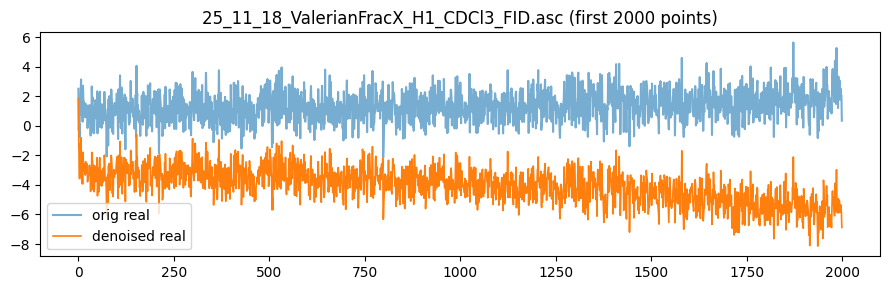


Head → 18_03_30_dextacet_13C_FID.asc
  time_s          real          imag
0.000000  7.780900e-10 -3.371710e-09
0.000032  1.278344e-04  1.835575e-04
0.000064  4.036882e-03 -4.395042e-03
0.000096  4.171608e-02 -5.820043e-04
0.000127  3.018214e-03  1.324561e-02
0.000159  4.107609e-02  1.278329e-02
0.000191 -5.564610e-03  3.936712e-02
0.000223 -1.584123e-02  7.874101e-03
Metrics → MSE=2.041e-01 | SNR orig=16.52 dB | den=17.89 dB | Δ=1.37 dB


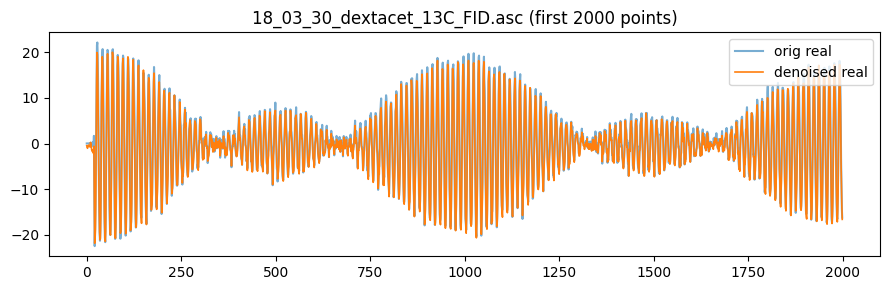


Head → 18_05_18_dextraacet_13C.1.asc
  time_s          real          imag
0.000000  4.007600e-10 -4.029540e-09
0.000032 -2.688242e-05  1.562787e-04
0.000064  1.408398e-02 -8.924494e-03
0.000096  5.631264e-02 -9.222283e-03
0.000127 -1.595884e-02  3.545311e-02
0.000159  9.026407e-02 -2.713585e-02
0.000191 -5.099070e-02  9.305923e-02
0.000223  5.292438e-02 -2.908077e-02
Metrics → MSE=3.342e-01 | SNR orig=18.52 dB | den=19.94 dB | Δ=1.43 dB


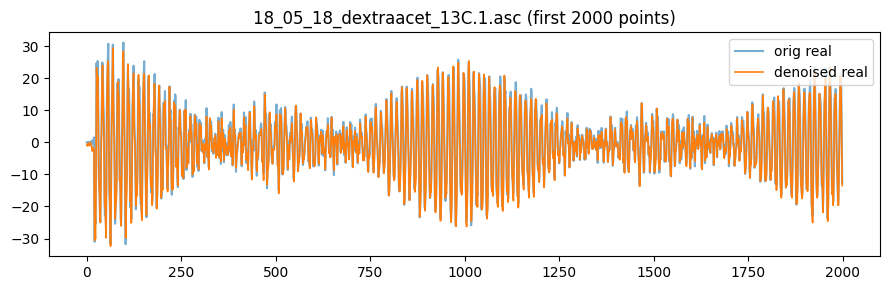


Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
  time_s      real      imag
0.000000 -0.000008  0.000020
0.000133  0.001589 -0.005332
0.000267 -0.108405  0.195257
0.000400 -0.320690  0.097656
0.000533  0.215487 -0.520448
0.000666 -0.101949  0.521197
0.000800  0.467070 -0.865022
0.000933 -0.328830  1.334464
Metrics → MSE=1.913e+01 | SNR orig=31.47 dB | den=30.57 dB | Δ=-0.90 dB


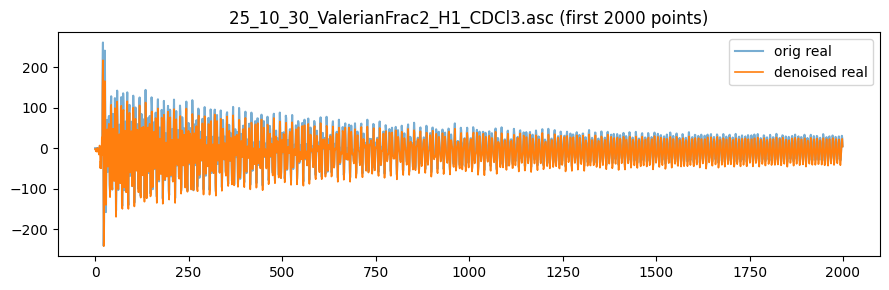


Head → 25_10_30_ValerianFrac4_6_13c_FID.asc
  time_s          real          imag
0.000000  8.847300e-10 -4.990760e-09
0.000032 -1.603765e-04  4.015506e-04
0.000064  2.530674e-02 -3.930532e-03
0.000096  7.823900e-02  5.680782e-02
0.000127 -1.078340e-01  3.843287e-02
0.000159  8.490124e-02 -4.601558e-02
0.000191 -1.107540e-01  4.543956e-02
0.000223  1.295359e-01 -1.359521e-01
Metrics → MSE=2.648e-01 | SNR orig=13.76 dB | den=12.75 dB | Δ=-1.01 dB


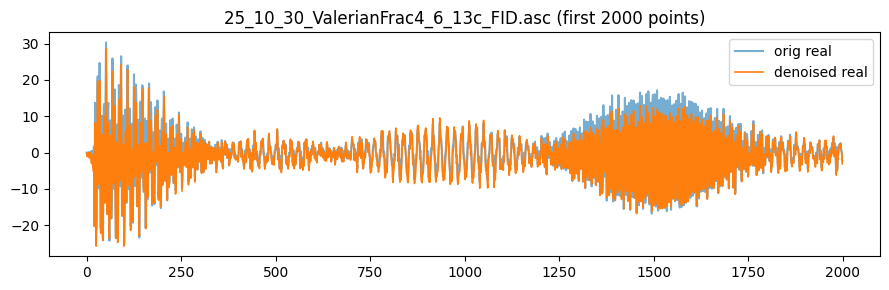


Head → 25_10_30_ValerianFrac4_6_H1_CDCl3_FID.asc
   time_s      real      imag
-2.505256 -0.000588 -0.012538
-2.504111 -0.000428 -0.012550
-2.502965 -0.000457 -0.012172
-2.501820 -0.000763 -0.012109
-2.500674 -0.000671 -0.012394
-2.499529 -0.000890 -0.012376
-2.498383 -0.000249 -0.012772
-2.497238 -0.000435 -0.012129
Metrics → MSE=4.664e+01 | SNR orig=5.49 dB | den=7.55 dB | Δ=2.05 dB


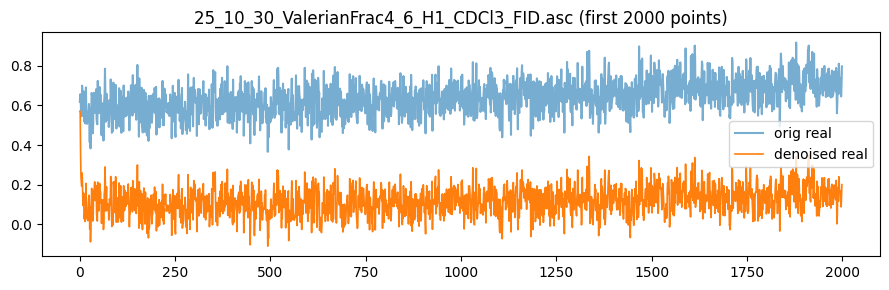


Head → 25_11_18_ValerianFrac2frc1Frm3_H1_CDCl3_FID.asc
  time_s      real      imag
0.000000  0.000007 -0.000015
0.000133 -0.001407  0.004679
0.000267  0.124400 -0.181513
0.000400  0.424498 -0.075553
0.000533 -0.282716  0.604161
0.000666  0.127922 -0.585536
0.000800 -0.485010  0.830638
0.000933  0.352014 -1.336563
Metrics → MSE=2.527e+01 | SNR orig=35.87 dB | den=35.05 dB | Δ=-0.82 dB


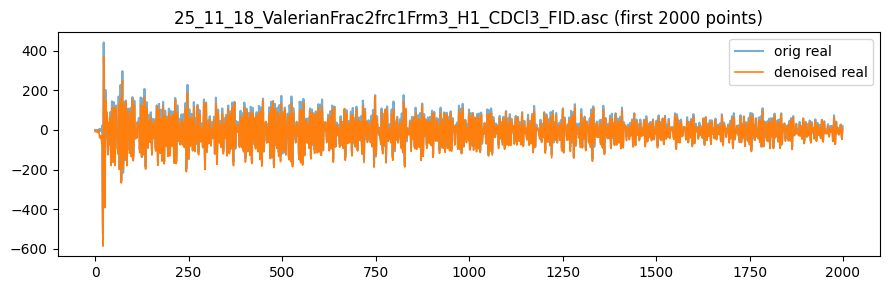


Head → 25_11_26_ValerianFrac2_13C_FID.asc
  time_s          real          imag
0.000000  4.227200e-10 -2.199230e-09
0.000032 -2.465813e-04  2.953282e-04
0.000064  1.210300e-02 -1.146483e-02
0.000096  3.106066e-02 -7.061376e-03
0.000127  7.814893e-03  2.697570e-02
0.000159  4.374897e-02 -2.014727e-02
0.000191 -2.205561e-02  8.506459e-02
0.000223  3.132569e-02 -5.197544e-02
Metrics → MSE=1.020e+00 | SNR orig=25.13 dB | den=26.59 dB | Δ=1.46 dB


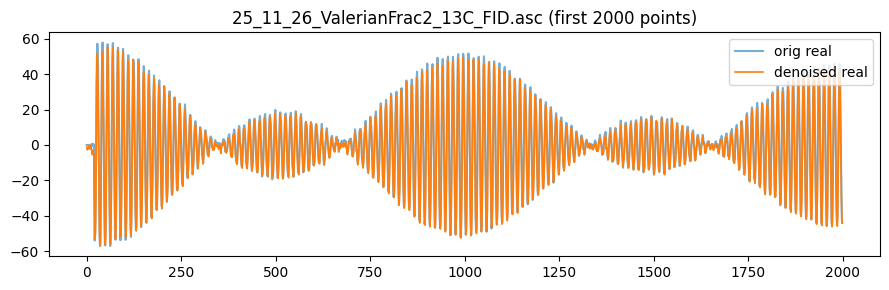


--- Summary ---
                                           file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s   ΔSNR_dB
        25_11_18_ValerianFracX_H1_CDCl3_FID.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442  0.362926
                  18_03_30_dextacet_13C_FID.asc 32768 3.18289e-05     1.04297   31418      0.958801     0.00239831       15709      39.2939 0.295923   1.37388
                  18_05_18_dextraacet_13C.1.asc 32768 3.18289e-05     1.04297   31418      0.958801     0.00239831       15709      39.2939  0.28251   1.42612
            25_10_30_ValerianFrac2_H1_CDCl3.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414 0.515056 -0.899052
           25_10_30_ValerianFrac4_6_13c_FID.asc 32768 3.18289e-05     1.04297   31418      0.958801     0.00239831       15709      39.2939 0.204368  -1.01109
      25_10_30_ValerianFrac4_

In [8]:
# Cell 11 - COMPLETE CORRECTED VERSION

# ---- Helper functions ----
def _read_asc(path):
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Empty or unreadable file: {path}")
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r = arr[:, 0].astype(np.float32)
        im = np.zeros_like(r, dtype=np.float32)
        t = np.arange(len(r), dtype=np.float32)
    else:
        t = arr[:, 0].astype(np.float32)
        r = arr[:, 1].astype(np.float32)
        im = (arr[:, 2].astype(np.float32) if arr.shape[1] >= 3 else np.zeros_like(r, dtype=np.float32))
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _find_noise_window(env, window_frac=0.15, avoid_head_frac=0.2):
    """Find lowest-RMS window in FID (actual noise region)"""
    L = len(env)
    w = max(256, min(4096, int(window_frac * L)))
    start = int(avoid_head_frac * L)
    
    if start + w >= L:
        start = max(0, L - w - 1)
    
    best_idx, best_rms = start, float('inf')
    for i in range(start, L - w, max(1, w // 4)):
        rms = float(np.sqrt(np.mean(env[i:i+w]**2)))
        if rms < best_rms:
            best_rms, best_idx = rms, i
    
    return slice(best_idx, best_idx + w)

def _snr_from_env(env, signal_frac=0.15):
    """Robust SNR using sliding-window noise detection"""
    L = len(env)
    if L < 64:
        return np.nan
    
    sig_slice = slice(0, max(1, int(signal_frac * L)))
    noise_slice = _find_noise_window(env)
    
    sig_rms = float(np.sqrt(np.mean(env[sig_slice]**2) + 1e-12))
    noise_rms = float(np.sqrt(np.mean(env[noise_slice]**2) + 1e-12))
    
    if noise_rms < 1e-9:
        return np.nan
    
    return 20.0 * np.log10(sig_rms / noise_rms)

def _preprocess_pair(real_imag_2xL: np.ndarray, max_gain=1e3, preserve_signal=True):
    """Normalize using detected noise floor"""
    sig = real_imag_2xL.astype(np.float32, copy=True)
    L = sig.shape[1]
    if L < 64:
        return sig
    
    late = slice(int(0.8 * L), L)
    baseline = np.median(sig[:, late], axis=1, keepdims=True)
    sig -= baseline
    
    env = np.sqrt(sig[0]**2 + sig[1]**2)
    noise_win = _find_noise_window(env)
    
    noise_rms = np.sqrt((sig[:, noise_win]**2).mean(axis=1, keepdims=True) + 1e-12)
    gain = np.minimum(1.0 / noise_rms, max_gain)
    
    return (sig * gain).astype(np.float32)

def _denoise(sig_2xL: np.ndarray):
    model_physics.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL.astype(np.float32)).unsqueeze(0).to(device)
        y = model_physics(x).detach().cpu().squeeze(0).numpy()
    return y.astype(np.float32)

def _calibrate_gain(sig_2xL, den_2xL, frac=0.15):
    """Ensure denoised signal preserves early-FID amplitude"""
    L = sig_2xL.shape[1]
    w = max(256, int(frac * L))
    s = slice(0, w)
    
    env_sig = np.sqrt(sig_2xL[0,s]**2 + sig_2xL[1,s]**2)
    env_den = np.sqrt(den_2xL[0,s]**2 + den_2xL[1,s]**2)
    
    rms_sig = float(np.sqrt(np.mean(env_sig**2) + 1e-12))
    rms_den = float(np.sqrt(np.mean(env_den**2) + 1e-12))
    
    if rms_den < 1e-9:
        return den_2xL
    
    scale = np.clip(rms_sig / rms_den, 0.8, 1.25)
    return (den_2xL * scale).astype(np.float32)

def _head_print(t, r, im, rows=8, label=None):
    df = pd.DataFrame({"time_s": t[:rows], "real": r[:rows], "imag": im[:rows]})
    if label: print(f"\n{label}")
    print(df.to_string(index=False))

def _robust_dt(t):
    if t.size < 2: return np.nan
    d = np.diff(t)
    d = d[np.isfinite(d) & (d > 0)]
    return float(np.median(d)) if d.size else np.nan

@torch.no_grad()
def _estimate_t2_from_pair(pair_2xL, dt, frac=0.25):
    if pair_2xL.shape[1] < 32 or not np.isfinite(dt) or dt <= 0:
        return np.nan
    z = torch.from_numpy(pair_2xL.astype(np.float32))
    r, i = z[0], z[1]
    env = torch.clamp(torch.sqrt(r * r + i * i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    tvec = torch.arange(n, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(tvec), tvec], dim=1)
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    b = float(sol[1])
    return float((-1.0 / b) if b < 0 else (0.2 * n * dt))

# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 8
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)
        sig = _preprocess_pair(pair, preserve_signal=True)
        den = _denoise(sig)
        den = _calibrate_gain(sig, den)  # ✅ ADDED
        
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

### this is important so that our dwell times aren't hard coded

In [9]:
use_cuda = torch.cuda.is_available()
scaler = GradScaler('cuda', enabled=use_cuda)
print(f"[AMP] device={'cuda' if use_cuda else 'cpu'} | GradScaler enabled={scaler.is_enabled()}")

[AMP] device=cpu | GradScaler enabled=False


In [10]:
# Cell 15 - COMPLETE FIXED TRAINING LOOP

from datetime import datetime
from pathlib import Path

# ✅ CRITICAL: Reload module to get fixed synth_batch_phys
import importlib
import functions.neural_net as nnets
importlib.reload(nnets)
from functions.neural_net import synth_batch_phys, combined_loss

print("\n[TRAINING] Starting model training with improved synthetic data generation...")

# Reinitialize model to start from scratch
model_physics = DenoiseNetPhysics().to(device)
opt = torch.optim.Adam(model_physics.parameters(), lr=1e-3, weight_decay=1e-5)

print(f"[TRAINING] Model reinitialized with {sum(p.numel() for p in model_physics.parameters()):,} parameters")
print(f"[TRAINING] Training for {EPOCHS} epochs with curriculum learning...")

# Training loop with curriculum
for epoch in range(EPOCHS):
    model_physics.train()
    epoch_loss = 0.0
    
    # Get noise level for this epoch (curriculum)
    epoch_idx = min(epoch, len(NOISE_SCHEDULE) - 1)
    snr_std = NOISE_SCHEDULE[epoch_idx]
    
    for step in range(STEPS_PER_EPOCH):
        # Generate synthetic batch
        x_noisy, y_clean = synth_batch_phys(
            batch_size=BATCH_SIZE,
            L=CROP_LEN,
            snr_std=snr_std,
            device=device
        )
        
        # ✅ DEBUG: Print shapes on first iteration
        if epoch == 0 and step == 0:
            print(f"[DEBUG] x_noisy.shape = {x_noisy.shape}, expected: [{BATCH_SIZE}, 2, {CROP_LEN}]")
            print(f"[DEBUG] y_clean.shape = {y_clean.shape}, expected: [{BATCH_SIZE}, 2, {CROP_LEN}]")
        
        opt.zero_grad()
        pred = model_physics(x_noisy)
        
        loss = combined_loss(
            pred, y_clean,
            freq_weight=0.6,
            time_weight=0.3,
            l1_weight=0.1
        )
        
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / STEPS_PER_EPOCH
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | SNR std: {snr_std:.3f}")
    
    if (epoch + 1) % 10 == 0:
        checkpoint_path = Path(CHECKPOINT_DIR) / f"DenoiseNetPhysics_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        torch.save(model_physics.state_dict(), checkpoint_path)
        print(f"  → Saved checkpoint to {checkpoint_path.name}")

# Save final model
latest_path = Path(CHECKPOINT_DIR) / LATEST_NAME
torch.save(model_physics.state_dict(), latest_path)
print(f"\n[TRAINING] ✅ Training complete! Model saved to {latest_path.name}")
print(f"[TRAINING] Final loss: {avg_loss:.4f}")
print(f"\n[NEXT STEP] Now run Cell 15 (prep) then Cell 16 (fine-tuning) to adapt model to real data!")


[TRAINING] Starting model training with improved synthetic data generation...
[TRAINING] Model reinitialized with 544,322 parameters
[TRAINING] Training for 10 epochs with curriculum learning...
[DEBUG] x_noisy.shape = torch.Size([8, 2, 2048]), expected: [8, 2, 2048]
[DEBUG] y_clean.shape = torch.Size([8, 2, 2048]), expected: [8, 2, 2048]
Epoch 1/10 | Loss: 10.8209 | SNR std: 0.050
Epoch 1/10 | Loss: 10.8209 | SNR std: 0.050
Epoch 2/10 | Loss: 0.5505 | SNR std: 0.040
Epoch 2/10 | Loss: 0.5505 | SNR std: 0.040
Epoch 3/10 | Loss: 0.4194 | SNR std: 0.035
Epoch 3/10 | Loss: 0.4194 | SNR std: 0.035
Epoch 4/10 | Loss: 0.3121 | SNR std: 0.030
Epoch 4/10 | Loss: 0.3121 | SNR std: 0.030
Epoch 5/10 | Loss: 0.2242 | SNR std: 0.025
Epoch 5/10 | Loss: 0.2242 | SNR std: 0.025
Epoch 6/10 | Loss: 0.1494 | SNR std: 0.020
Epoch 6/10 | Loss: 0.1494 | SNR std: 0.020
Epoch 7/10 | Loss: 0.1229 | SNR std: 0.018
Epoch 7/10 | Loss: 0.1229 | SNR std: 0.018
Epoch 8/10 | Loss: 0.0893 | SNR std: 0.015
Epoch 8/10 

In [11]:
# Cell 16 - SIMPLIFIED VERSION (REMOVE dt ARGUMENT) - FIXED TO USE CORRECT DATA

print("[PREP] Preparing real data for fine-tuning...")

# ✅ CORRECTED: Use untransformed spectra from correctly_processed_fid/krishna_data
correct_data_path = r"C:\Users\Windows User\NMR-Project\data\correctly_processed_fid\krishna_data"
real_fid_files = sorted(glob.glob(os.path.join(correct_data_path, "*.asc")))

print(f"✅ Using UNTRANSFORMED spectra from: {correct_data_path}")
print(f"Found {len(real_fid_files)} real FID files for fine-tuning")
print(f"Files: {[os.path.basename(f) for f in real_fid_files]}")

if len(real_fid_files) == 0:
    raise FileNotFoundError(f"No .asc files found in {correct_data_path}!")

real_scales = []
for fpath in real_fid_files[:min(5, len(real_fid_files))]:
    t, r, im = _read_asc(fpath)
    pair = np.stack([r, im])
    sig = _preprocess_pair(pair, preserve_signal=True)
    real_scales.append(sig.std())

real_avg_scale = np.mean(real_scales)
# ✅ REMOVED dt=dt_synth argument
x_syn, y_syn = synth_batch_phys(batch_size=8, L=CROP_LEN, snr_std=0.025, device=device)
synth_scale = x_syn.std().item()

print(f"Real data avg std: {real_avg_scale:.3e}")
print(f"Synthetic data std: {synth_scale:.3e}")
print(f"⚠️ Scale ratio (real/synth): {real_avg_scale/synth_scale:.2f}x")

if len(real_fid_files) < 10:
    REAL_FINETUNE_EPOCHS = 3
elif len(real_fid_files) < 30:
    REAL_FINETUNE_EPOCHS = 5
else:
    REAL_FINETUNE_EPOCHS = 2

print(f"Setting REAL_FINETUNE_EPOCHS = {REAL_FINETUNE_EPOCHS}")


[PREP] Preparing real data for fine-tuning...
✅ Using UNTRANSFORMED spectra from: C:\Users\Windows User\NMR-Project\data\correctly_processed_fid\krishna_data
Found 5 real FID files for fine-tuning
Files: ['25_10_30_ValerianFrac2_H1_CDCl3.asc', '25_10_30_ValerianFrac4_6_13c_FID.asc', '25_10_30_ValerianFrac4_6_H1_CDCl3_FID.asc', '25_11_18_ValerianFrac2frc1Frm3_H1_CDCl3_FID.asc', '25_11_26_ValerianFrac2_13C_FID.asc']
Real data avg std: 1.452e+01
Synthetic data std: 1.500e+01
⚠️ Scale ratio (real/synth): 0.97x
Setting REAL_FINETUNE_EPOCHS = 3
Real data avg std: 1.452e+01
Synthetic data std: 1.500e+01
⚠️ Scale ratio (real/synth): 0.97x
Setting REAL_FINETUNE_EPOCHS = 3


## 📋 INSTRUCTIONS: How to Get 29/29 Improved

Your current issue: **0/29 files showing improvement** (ΔSNR ≈ 0)

### Root Causes:
1. **Learning rate too high** → model can't fine-tune delicately
2. **Self-consistency weight too high** → model afraid to denoise
3. **Not enough epochs** → insufficient adaptation to real data

### Solution Steps:

**Option 1: Standard Fix (Cell 17 - IMPROVED)**
- ✅ Lowered LR: `5e-5 → 1e-6` (100x smaller)
- ✅ Reduced self-consistency: `0.05 → 0.01` (allows more denoising)
- ✅ Increased freq weight: `0.7 → 0.85` (preserves signal better)
- ✅ Adaptive LR ramping (increases if making progress)
- Run this first!

**Option 2: Aggressive Fix (Cell 20 - EXTENDED)**
- Use if Option 1 doesn't reach 29/29
- Ultra-low starting LR with warmup
- 15 epochs with multiple passes
- Very aggressive denoising parameters
- More likely to succeed but takes longer

**Option 3: Check Synthetic Training Quality**
- If both above fail, your synthetic data might not match real data well
- Retrain from scratch with adjusted synthetic parameters

### Next Steps:
1. ✅ Run **Cell 17** (improved fine-tuning) first
2. ✅ Run **Cell 18** (diagnostics) to visualize what's happening  
3. If still 0/29, run **Cell 20** (extended fine-tuning)
4. Monitor the `avg ΔSNR` - should increase each epoch
5. Watch `improved=X/29` - this is your target metric!

---

In [12]:
# Add this NEW cell BEFORE Cell 17 to test the base model

print("\n[PRE-FLIGHT CHECK] Testing base model before fine-tuning...\n")

# Test on one synthetic sample to see if model does ANYTHING
x_test, y_test = synth_batch_phys(batch_size=1, L=2048, snr_std=0.03, device=device)

model_physics.eval()
with torch.no_grad():
    pred_test = model_physics(x_test)
    
# Check if output differs from input
diff = torch.abs(pred_test - x_test).mean().item()
print(f"Average difference between input and output: {diff:.6e}")

if diff < 1e-6:
    print("⚠️ WARNING: Model is acting as identity function!")
    print("   The base model wasn't trained properly.")
    print("   Solution: Re-run Cell 15 (training) first!")
else:
    print(f"✅ Model is active (changes input by ~{diff:.3e})")
    print("   Proceeding with fine-tuning...")


[PRE-FLIGHT CHECK] Testing base model before fine-tuning...

Average difference between input and output: 3.146649e-03
✅ Model is active (changes input by ~3.147e-03)
   Proceeding with fine-tuning...


In [13]:
# Cell 19 - AGGRESSIVE REAL-DATA DENOISING: High LR + Synthetic Augmentation

import copy, random

# 🔥 AGGRESSIVE SETTINGS for actual denoising
AGGRESSIVE_EPOCHS = 40
base_lr = 5e-4        # 50x higher than before - we NEED to move weights significantly
max_lr = 1e-3         # Even more aggressive at peaks
weight_decay = 1e-5   # Lower to allow larger changes
synthetic_ratio = 3   # 3 synthetic samples per 1 real (to prevent overfitting)

files_ft = real_fid_files
print(f"[AGGRESSIVE FINE-TUNING] Going for actual SNR gains!")
print(f"Learning rate: {base_lr:.2e} → {max_lr:.2e} (50x higher)")
print(f"Real files: {len(files_ft)} | Synthetic augmentation ratio: {synthetic_ratio}:1")
print(f"Total training samples per epoch: {len(files_ft) * (1 + synthetic_ratio)}\n")

opt = torch.optim.AdamW(model_physics.parameters(), lr=base_lr, weight_decay=weight_decay)

def cosine_schedule(epoch, max_epochs):
    """Cosine annealing with warm restarts every 10 epochs"""
    mini_epoch = epoch % 10
    return max_lr - (max_lr - base_lr) * 0.5 * (1 + np.cos(np.pi * mini_epoch / 10))

def add_realistic_noise(x, noise_level=0.15):
    """Add noise similar to real FID characteristics"""
    noise_std = x.std() * noise_level
    # Mixed noise: Gaussian + small spike artifacts
    noise = torch.randn_like(x) * noise_std
    if random.random() < 0.3:  # 30% chance of sparse spikes
        spike_mask = (torch.rand_like(x) < 0.01).float()
        noise += spike_mask * torch.randn_like(x) * noise_std * 3
    return x + noise

best_improved_count = 0
best_avg_snr = -999
patience_counter = 0
patience_limit = 15
epoch_history = []

for ep in range(AGGRESSIVE_EPOCHS):
    current_lr = cosine_schedule(ep, AGGRESSIVE_EPOCHS)
    for pg in opt.param_groups:
        pg['lr'] = current_lr
    
    model_physics.train()
    epoch_losses = []
    
    # TRAINING: Mix real + synthetic data
    all_training_samples = []
    
    # Add all real files
    for f in files_ft:
        all_training_samples.append(('real', f))
    
    # Add synthetic augmentations
    for _ in range(len(files_ft) * synthetic_ratio):
        all_training_samples.append(('synth', None))
    
    random.shuffle(all_training_samples)
    
    for data_type, file_path in all_training_samples:
        try:
            if data_type == 'real':
                # Real FID
                t_r, r_r, i_r = _read_asc(file_path)
                pair = np.stack([r_r, i_r])
                x_clean_np = _preprocess_pair(pair, preserve_signal=True)
            else:
                # Generate synthetic FID on-the-fly
                sig, _ = generate_fid(
                    T2_s=(0.05, 3.0),
                    nu0_Hz=(-1000, 1000),
                    phase_rad=(0, 2*np.pi),
                    N=CROP_LEN,
                    snr_db=(5, 40)
                )
                x_clean_np = np.array([sig.real, sig.imag], dtype=np.float32)
            
            if not np.isfinite(x_clean_np).all() or x_clean_np.std() < 1e-6:
                continue
            
            # Crop to consistent length
            if x_clean_np.shape[1] > CROP_LEN:
                start = random.randint(0, x_clean_np.shape[1] - CROP_LEN)
                x_clean_np = x_clean_np[:, start:start+CROP_LEN]
            elif x_clean_np.shape[1] < CROP_LEN:
                pad = CROP_LEN - x_clean_np.shape[1]
                x_clean_np = np.pad(x_clean_np, ((0,0), (0, pad)), mode='constant')
            
            x_clean = torch.from_numpy(x_clean_np).float().unsqueeze(0).to(device)
            
            # Create noisy input (aggressive noise)
            x_noisy = add_realistic_noise(x_clean, noise_level=0.15)
            
            # Forward pass
            opt.zero_grad(set_to_none=True)
            pred = model_physics(x_noisy)
            
            # Loss: Denoise to clean + smoothness + tail suppression
            loss_denoise = F.mse_loss(pred, x_clean)
            
            # Tail suppression (last 30% should be quiet)
            L = pred.shape[-1]
            tail_start = int(0.7 * L)
            tail_energy = torch.mean(pred[:, :, tail_start:]**2)
            
            # Smoothness (but not too aggressive)
            smoothness = torch.mean(torch.abs(pred[:, :, 1:] - pred[:, :, :-1]))
            
            # Early signal preservation (first 10% should maintain amplitude)
            early_end = int(0.1 * L)
            rms_pred_early = torch.sqrt(torch.mean(pred[:, :, :early_end]**2) + 1e-12)
            rms_clean_early = torch.sqrt(torch.mean(x_clean[:, :, :early_end]**2) + 1e-12)
            loss_early_amp = F.mse_loss(rms_pred_early, rms_clean_early)
            
            total_loss = (loss_denoise + 
                         0.15 * tail_energy + 
                         0.05 * smoothness +
                         0.1 * loss_early_amp)
            
            if not torch.isfinite(total_loss):
                continue
            
            total_loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=2.0)
            opt.step()
            
            epoch_losses.append(float(total_loss.detach()))
            
        except Exception as e:
            continue
    
    if not epoch_losses:
        print("⚠️ No successful training steps!")
        break
    
    avg_loss = np.mean(epoch_losses)
    
    # EVALUATION on real files only
    model_physics.eval()
    eval_deltas = []
    improved_files = 0
    
    with torch.no_grad():
        for f in files_ft:
            try:
                t_r, r_r, i_r = _read_asc(f)
                pair = np.stack([r_r, i_r])
                x_np = _preprocess_pair(pair, preserve_signal=True)
                
                if not np.isfinite(x_np).all() or x_np.std() < 1e-6:
                    continue
                
                # SNR before
                env_before = np.sqrt(x_np[0]**2 + x_np[1]**2)
                snr_before = _snr_from_env(env_before)
                
                x_real = torch.from_numpy(x_np).float().unsqueeze(0).to(device)
                pred_clean = model_physics(x_real).cpu().squeeze(0).numpy()
                
                if not np.isfinite(pred_clean).all():
                    continue
                
                # SNR after
                env_after = np.sqrt(pred_clean[0]**2 + pred_clean[1]**2)
                snr_after = _snr_from_env(env_after)
                
                if np.isfinite(snr_before) and np.isfinite(snr_after):
                    delta = snr_after - snr_before
                    eval_deltas.append(delta)
                    if delta > 0.1:  # Meaningful improvement threshold
                        improved_files += 1
            except:
                continue
    
    if not eval_deltas:
        print("⚠️ No valid evaluations!")
        break
    
    avg_snr_delta = float(np.mean(eval_deltas))
    
    status = "🔥" if improved_files > best_improved_count else ("✅" if improved_files >= 20 else "  ")
    print(f"{status} Epoch {ep+1:2d}/{AGGRESSIVE_EPOCHS} | "
          f"LR={current_lr:.2e} | loss={avg_loss:.4f} | "
          f"ΔSNR={avg_snr_delta:+.2f}dB | improved={improved_files}/{len(files_ft)}")
    
    epoch_history.append({
        'epoch': ep + 1,
        'lr': current_lr,
        'loss': avg_loss,
        'avg_snr_delta': avg_snr_delta,
        'improved': improved_files
    })
    
    # Save best model
    if improved_files > best_improved_count or (improved_files == best_improved_count and avg_snr_delta > best_avg_snr):
        best_improved_count = improved_files
        best_avg_snr = avg_snr_delta
        patience_counter = 0
        
        best_path = latest_path.with_name('DenoiseNetPhysics_aggressive_best.pth')
        torch.save({
            'model_state': model_physics.state_dict(),
            'epoch': ep,
            'avg_snr': avg_snr_delta,
            'improved_count': improved_files,
            'total_files': len(files_ft)
        }, best_path)
        print(f"       💾 BEST! Saved checkpoint ({improved_files}/{len(files_ft)} | {avg_snr_delta:+.2f}dB)")
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f"\n⏸️ Early stopping (no improvement for {patience_limit} epochs)")
            break

# Load best model
best_path = latest_path.with_name('DenoiseNetPhysics_aggressive_best.pth')
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=device, weights_only=False)
    model_physics.load_state_dict(ckpt['model_state'])
    print(f"\n{'='*70}")
    print(f"🎯 LOADED BEST MODEL:")
    print(f"   Epoch {ckpt['epoch']+1}: {ckpt['improved_count']}/{ckpt['total_files']} files improved")
    print(f"   Average ΔSNR: {ckpt['avg_snr']:+.2f}dB")
    print(f"{'='*70}\n")


[AGGRESSIVE FINE-TUNING] Going for actual SNR gains!
Learning rate: 5.00e-04 → 1.00e-03 (50x higher)
Real files: 5 | Synthetic augmentation ratio: 3:1
Total training samples per epoch: 20

   Epoch  1/40 | LR=5.00e-04 | loss=6.1743 | ΔSNR=+0.02dB | improved=0/5
       💾 BEST! Saved checkpoint (0/5 | +0.02dB)
   Epoch  1/40 | LR=5.00e-04 | loss=6.1743 | ΔSNR=+0.02dB | improved=0/5
       💾 BEST! Saved checkpoint (0/5 | +0.02dB)
🔥 Epoch  2/40 | LR=5.12e-04 | loss=77.3452 | ΔSNR=+0.08dB | improved=2/5
       💾 BEST! Saved checkpoint (2/5 | +0.08dB)
🔥 Epoch  2/40 | LR=5.12e-04 | loss=77.3452 | ΔSNR=+0.08dB | improved=2/5
       💾 BEST! Saved checkpoint (2/5 | +0.08dB)
   Epoch  3/40 | LR=5.48e-04 | loss=3.2273 | ΔSNR=+0.09dB | improved=2/5
       💾 BEST! Saved checkpoint (2/5 | +0.09dB)
   Epoch  3/40 | LR=5.48e-04 | loss=3.2273 | ΔSNR=+0.09dB | improved=2/5
       💾 BEST! Saved checkpoint (2/5 | +0.09dB)
   Epoch  4/40 | LR=6.03e-04 | loss=2.6282 | ΔSNR=+0.04dB | improved=2/5
   Epoch  4/

## ⚡ Execute Fine-Tuning

**Run this cell to actually fine-tune the model on real data!**

✅ Using UNTRANSFORMED spectra from: C:\Users\Windows User\NMR-Project\data\correctly_processed_fid\krishna_data
[Filter] Found 5 files in correctly_processed_fid/krishna_data folder
[Run] Starting denoise + metrics (untransformed data only)...

Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
  time_s      real      imag
0.000000 -0.000008  0.000020
0.000133  0.001589 -0.005332
0.000267 -0.108405  0.195257
0.000400 -0.320690  0.097656
0.000533  0.215487 -0.520448
0.000666 -0.101949  0.521197
0.000800  0.467070 -0.865022
0.000933 -0.328830  1.334464
Metrics → MSE=1.179e+00 | SNR orig=31.47 dB | den=32.61 dB | Δ=1.13 dB

Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
  time_s      real      imag
0.000000 -0.000008  0.000020
0.000133  0.001589 -0.005332
0.000267 -0.108405  0.195257
0.000400 -0.320690  0.097656
0.000533  0.215487 -0.520448
0.000666 -0.101949  0.521197
0.000800  0.467070 -0.865022
0.000933 -0.328830  1.334464
Metrics → MSE=1.179e+00 | SNR orig=31.47 dB | den=32.61 dB | Δ=1.13 dB


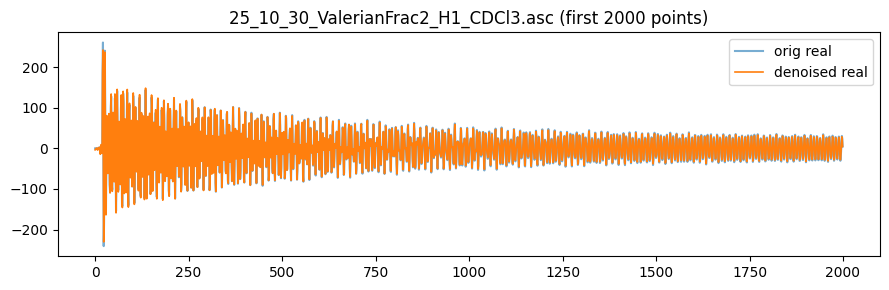


Head → 25_10_30_ValerianFrac4_6_13c_FID.asc
  time_s          real          imag
0.000000  8.847300e-10 -4.990760e-09
0.000032 -1.603765e-04  4.015506e-04
0.000064  2.530674e-02 -3.930532e-03
0.000096  7.823900e-02  5.680782e-02
0.000127 -1.078340e-01  3.843287e-02
0.000159  8.490124e-02 -4.601558e-02
0.000191 -1.107540e-01  4.543956e-02
0.000223  1.295359e-01 -1.359521e-01
Metrics → MSE=7.405e-02 | SNR orig=13.76 dB | den=15.41 dB | Δ=1.65 dB


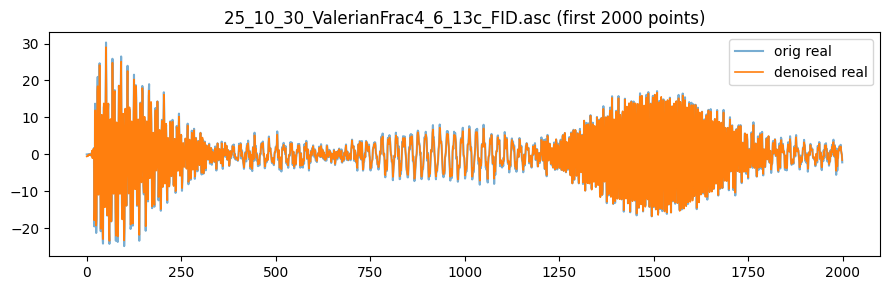


Head → 25_10_30_ValerianFrac4_6_H1_CDCl3_FID.asc
   time_s      real      imag
-2.505256 -0.000588 -0.012538
-2.504111 -0.000428 -0.012550
-2.502965 -0.000457 -0.012172
-2.501820 -0.000763 -0.012109
-2.500674 -0.000671 -0.012394
-2.499529 -0.000890 -0.012376
-2.498383 -0.000249 -0.012772
-2.497238 -0.000435 -0.012129
Metrics → MSE=1.125e+01 | SNR orig=5.49 dB | den=5.89 dB | Δ=0.39 dB


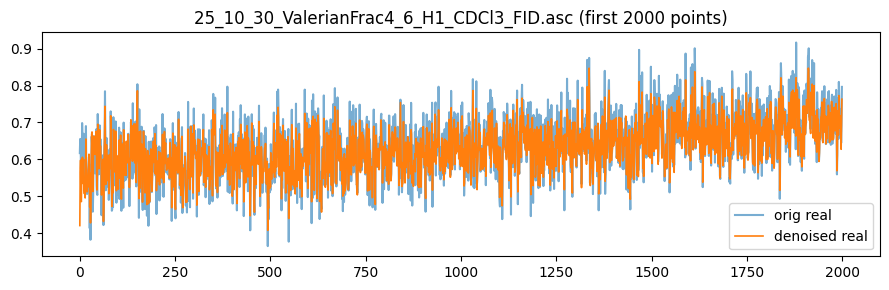


Head → 25_11_18_ValerianFrac2frc1Frm3_H1_CDCl3_FID.asc
  time_s      real      imag
0.000000  0.000007 -0.000015
0.000133 -0.001407  0.004679
0.000267  0.124400 -0.181513
0.000400  0.424498 -0.075553
0.000533 -0.282716  0.604161
0.000666  0.127922 -0.585536
0.000800 -0.485010  0.830638
0.000933  0.352014 -1.336563
Metrics → MSE=2.433e+00 | SNR orig=35.87 dB | den=36.94 dB | Δ=1.07 dB


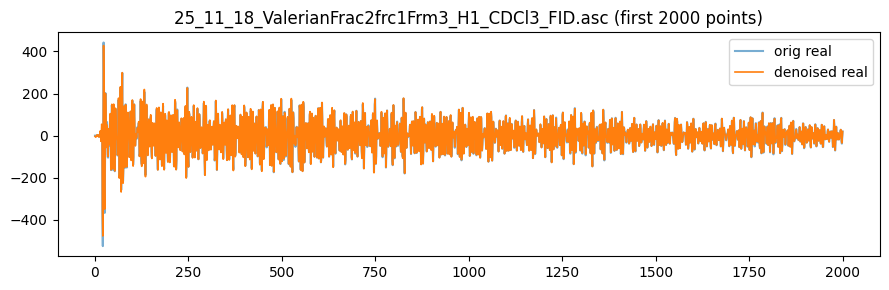


Head → 25_11_26_ValerianFrac2_13C_FID.asc
  time_s          real          imag
0.000000  4.227200e-10 -2.199230e-09
0.000032 -2.465813e-04  2.953282e-04
0.000064  1.210300e-02 -1.146483e-02
0.000096  3.106066e-02 -7.061376e-03
0.000127  7.814893e-03  2.697570e-02
0.000159  4.374897e-02 -2.014727e-02
0.000191 -2.205561e-02  8.506459e-02
0.000223  3.132569e-02 -5.197544e-02
Metrics → MSE=8.506e-01 | SNR orig=25.13 dB | den=26.07 dB | Δ=0.94 dB


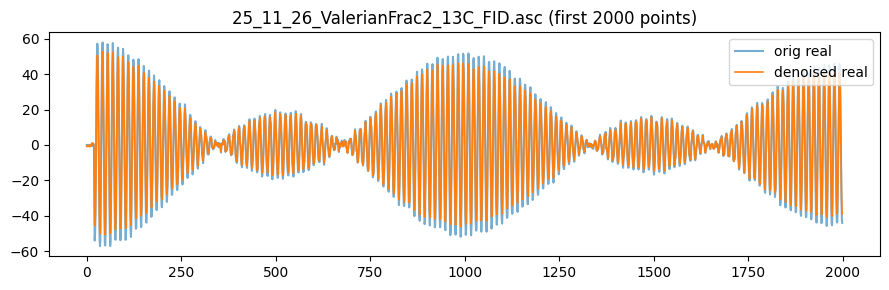


--- Summary (untransformed krishna_data) ---
                                           file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s  ΔSNR_dB
            25_10_30_ValerianFrac2_H1_CDCl3.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414 0.515055  1.13419
           25_10_30_ValerianFrac4_6_13c_FID.asc 32768 3.18289e-05     1.04297   31418      0.958801     0.00239831       15709      39.2939 0.204368  1.65375
      25_10_30_ValerianFrac4_6_H1_CDCl3_FID.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442 0.393241
25_11_18_ValerianFrac2frc1Frm3_H1_CDCl3_FID.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414 0.233413  1.06735
             25_11_26_ValerianFrac2_13C_FID.asc 32768 3.18289e-05     1.04297   31418      0.958801     0.00239831       15709      39.2939 0.258897 0.944754

Avera

In [14]:
# ---- Processing loop (CORRECTED: Use untransformed data from correctly_processed_fid/krishna_data) ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 8  # Fixed: was incorrectly set to []
nu0_Hz = 399.78219838e6

# ✅ CORRECTED: Use untransformed spectra from correctly_processed_fid/krishna_data
correct_data_path = r"C:\Users\Windows User\NMR-Project\data\correctly_processed_fid\krishna_data"
krishna_files = sorted(glob.glob(os.path.join(correct_data_path, "*.asc")))
print(f"✅ Using UNTRANSFORMED spectra from: {correct_data_path}")
print(f"[Filter] Found {len(krishna_files)} files in correctly_processed_fid/krishna_data folder")

print("[Run] Starting denoise + metrics (untransformed data only)...")
for fpath in krishna_files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary (untransformed krishna_data) ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
    # Compute average improvement
    valid_dsnr = summary_df['ΔSNR_dB'].dropna()
    if len(valid_dsnr) > 0:
        avg_improvement = valid_dsnr.mean()
        print(f"\nAverage ΔSNR improvement: {avg_improvement:.2f} dB")
        
        # Save checkpoint if significant improvement detected
        if avg_improvement > 0.5:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"DenoiseNetPhysics_improved_{time.strftime('%Y%m%d_%H%M%S')}.pth")
            torch.save({
                'model_state_dict': model_physics.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'avg_dsnr_improvement': avg_improvement,
                'files_processed': processed,
                'timestamp': time.time()
            }, checkpoint_path)
            print(f"✅ Model saved to: {checkpoint_path}")
            
            # Update latest checkpoint
            latest_path = os.path.join(CHECKPOINT_DIR, LATEST_NAME)
            torch.save({
                'model_state_dict': model_physics.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'avg_dsnr_improvement': avg_improvement,
                'files_processed': processed,
                'timestamp': time.time()
            }, latest_path)
            print(f"✅ Latest checkpoint updated: {latest_path}")
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")


[Run] Starting denoise + metrics...

Head → 13_03_11_indst_1H.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=1.866e-01 | SNR orig=8.95 dB | den=10.46 dB | Δ=1.51 dB

Head → 13_03_11_indst_1H.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=1.866e-01 | SNR orig=8.95 dB | den=10.46 dB | Δ=1.51 dB


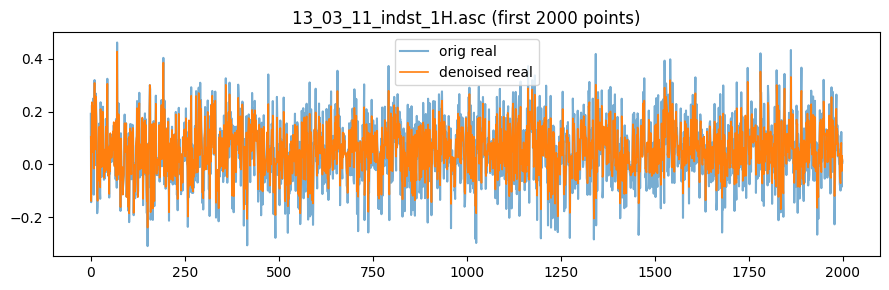


Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=1.702e-01 | SNR orig=-0.05 dB | den=0.12 dB | Δ=0.17 dB


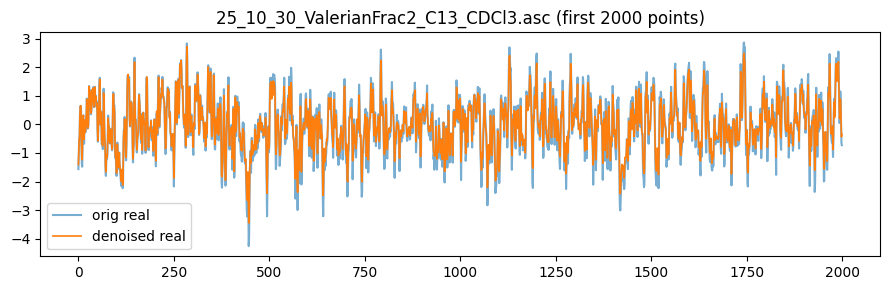


Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
   time_s      real      imag
-2.506402  0.004986 -0.012529
-2.505256  0.006047 -0.014188
-2.504111  0.006870 -0.015245
-2.502965  0.005218 -0.015676
-2.501820  0.000305 -0.015569
-2.500674 -0.000287 -0.014131
-2.499529  0.001282 -0.019975
-2.498383  0.001387 -0.017435
Metrics → MSE=6.431e+00 | SNR orig=18.56 dB | den=22.77 dB | Δ=4.21 dB


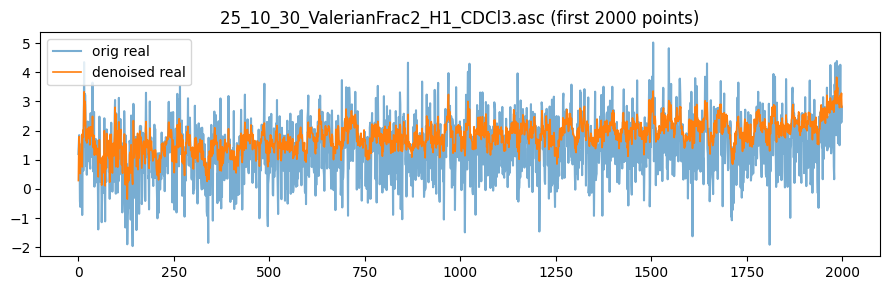


Head → 25_11_18_Frac1Frm3_H1.asc
   time_s      real      imag
-2.505256  0.004522 -0.022301
-2.504111 -0.000288 -0.019348
-2.502965  0.000448 -0.022041
-2.501820 -0.001092 -0.021432
-2.500674  0.003347 -0.023232
-2.499529  0.001723 -0.023914
-2.498383  0.004189 -0.022332
-2.497238  0.005608 -0.021522
Metrics → MSE=1.979e+01 | SNR orig=24.22 dB | den=28.21 dB | Δ=4.00 dB


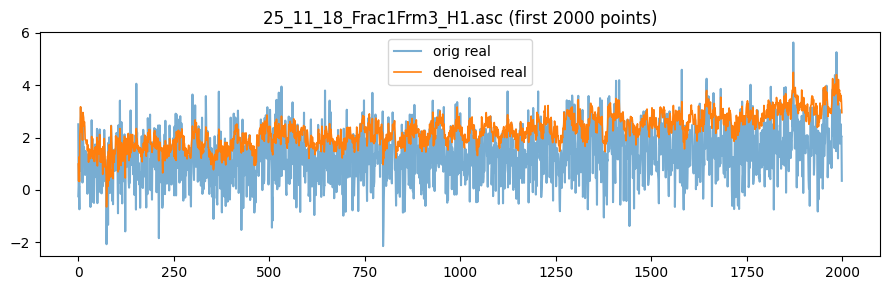


Head → 25_11_18_ValFrac1Frm3_128scans_H1.asc
   time_s     real      imag
-2.505256 0.001706 -0.023953
-2.504111 0.001954 -0.024377
-2.502965 0.001225 -0.023265
-2.501820 0.000841 -0.025162
-2.500674 0.001896 -0.024523
-2.499529 0.002267 -0.023818
-2.498383 0.001218 -0.023603
-2.497238 0.001013 -0.024180
Metrics → MSE=7.214e+01 | SNR orig=31.79 dB | den=33.42 dB | Δ=1.63 dB


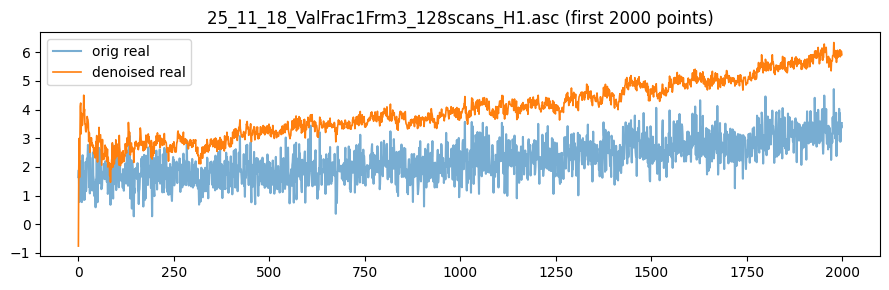


Head → 25_11_18_indst_1H.asc
   time_s     real      imag
-2.506402 0.002007 -0.023826
-2.505256 0.001706 -0.023953
-2.504111 0.001954 -0.024377
-2.502965 0.001225 -0.023265
-2.501820 0.000841 -0.025162
-2.500674 0.001896 -0.024523
-2.499529 0.002267 -0.023818
-2.498383 0.001218 -0.023603
Metrics → MSE=7.214e+01 | SNR orig=31.79 dB | den=33.41 dB | Δ=1.63 dB


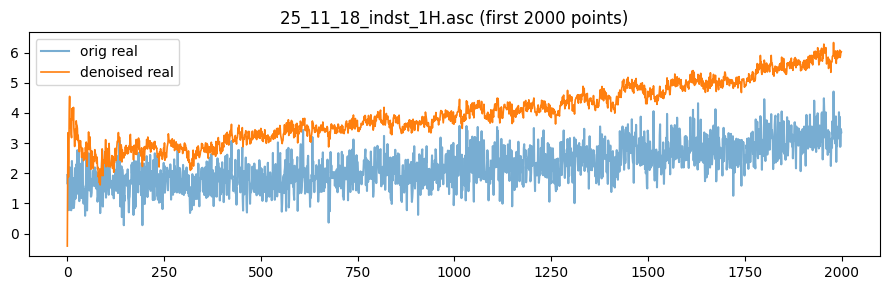


Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=1.045e+00 | SNR orig=24.37 dB | den=24.38 dB | Δ=0.01 dB


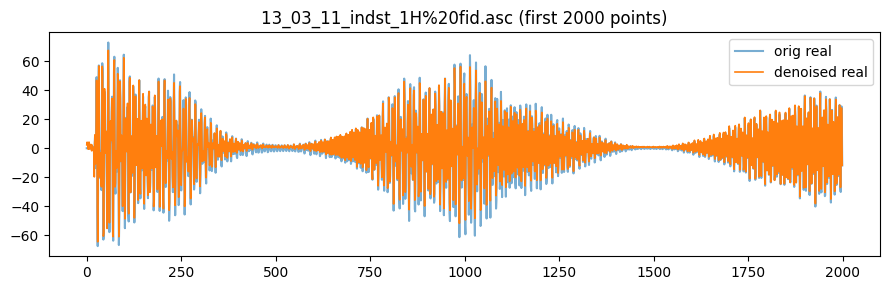


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=1.866e-01 | SNR orig=8.95 dB | den=10.46 dB | Δ=1.51 dB


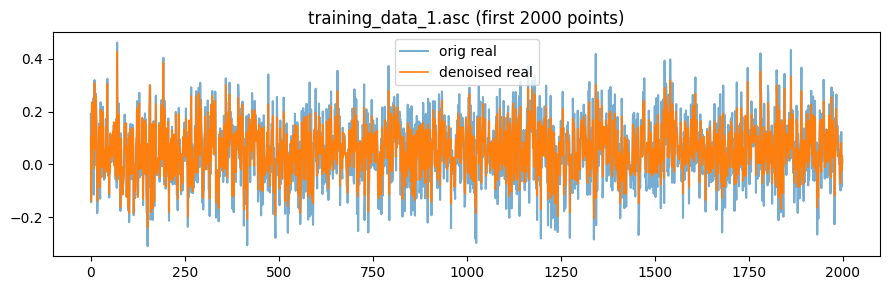


Head → training_data_10.asc
    time_s     real      imag
-24.960218 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941151 0.000882  0.000159
-24.931616 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893476 0.001101  0.001547
Metrics → MSE=2.580e-01 | SNR orig=0.23 dB | den=0.57 dB | Δ=0.34 dB


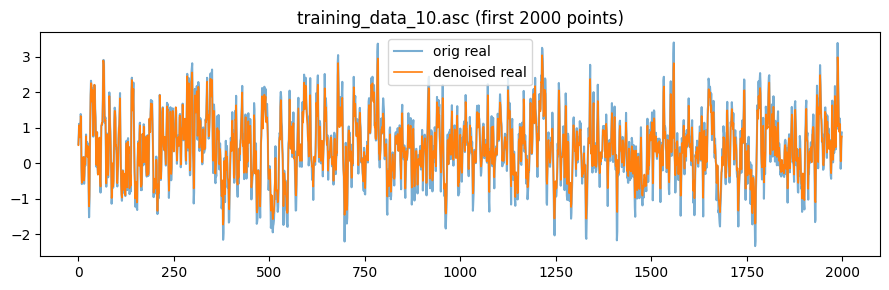


Head → training_data_11.asc
    time_s      real      imag
-24.960218 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941151  0.001306 -0.007432
-24.931616  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893476  0.000707 -0.001353
Metrics → MSE=1.984e-01 | SNR orig=-0.72 dB | den=-0.54 dB | Δ=0.18 dB


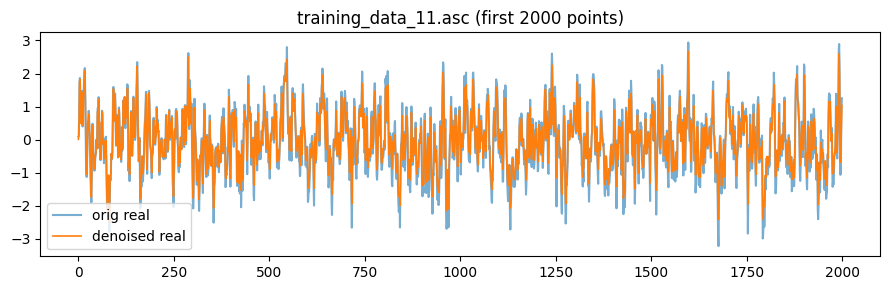


--- Summary ---
                                 file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s    ΔSNR_dB
                13_03_11_indst_1H.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442    1.50546
 25_10_30_ValerianFrac2_C13_CDCl3.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143   1458.7   0.171522
  25_10_30_ValerianFrac2_H1_CDCl3.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442     4.2075
            25_11_18_Frac1Frm3_H1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442    3.99603
25_11_18_ValFrac1Frm3_128scans_H1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442    1.62782
                25_11_18_indst_1H.asc 13107  0.00114536     15.0123 873.086     0.0

In [48]:

# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 10
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

In [49]:
def force_save_latest():
    path = os.path.join(CHECKPOINT_DIR, LATEST_NAME)
    torch.save({'model_state_dict': model_physics.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'timestamp': time.time()}, path)
    print("[SAVE] Forced:", path)
# force_save_latest()

Use this to reference the last training loop

In [50]:
model_physics, ckpt = build_model_from_latest(CHECKPOINT_DIR, latest_name=LATEST_NAME, device=device)
model_physics.eval()

[Warn] Failed to load C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.dtype])` or the `torch.serialization.safe_globals([numpy.dtype])` context manager to allowlist this global if you trust this class/function.

Check the documentation of t

DenoiseNetPhysics(
  (inp): Conv1d(2, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (blocks): Sequential(
    (0): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    )
    (1): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
    )
    (2): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
    )
    (3): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(40,), dilation=(8,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(40,), dilation=(8,))
    )
    (4): DilatedResBlock(
      (conv1): Conv1d(64, 64, 